In [1]:
# --------------------------------------------------------------------
# 1. Imports and Config
# --------------------------------------------------------------------
import pandas as pd
import os
from tqdm import tqdm
import time
from huggingface_hub import InferenceClient
import ast
import re
import string
import textwrap
import matplotlib.pyplot as plt
import json
import numpy as np

client = InferenceClient(
    provider="together",
    api_key="tgp_v1_5oc-cc8ND7yxBiomi-BILcdKjDdaS7samHhpA_m4u4c",
)

LLAMA_MODEL = "meta-llama/Llama-3.3-70B-Instruct"
TEMPERATURE = 1
TOP_P = 1
MAX_TOKENS = 800
N = 1

data_long = pd.read_csv('../Data/data_long.csv')
output_path = '../Output/chunked_transcriptions.csv'
os.makedirs('../Output', exist_ok=True)

In [3]:
chunking_prompt = """
You are an expert in cognitive psychology and verbal protocol analysis.

You are given a transcription of a participant thinking aloud while solving a problem.

Your task is to segment this transcription into meaningful chunks.

A chunk should correspond to a coherent idea, thought, or step in the participant's reasoning or verbal expression — including hesitations, repetitions, or meta-comments. The goal is not only to segment explicit reasoning steps but to preserve the full structure of the verbalization.

Guidelines:
- Do not remove or suppress any part of the original text.
- Do not segment based on arbitrary word count or length.
- Split only when the participant clearly moves to another distinct thought, idea, or reasoning step (e.g., shifting from generating an answer to justifying it, or reflecting on their uncertainty).
- Be conservative in splitting: avoid unnecessary fragmentation.
- Preserve the original wording exactly in each chunk.

Provide your output strictly in the following structure:

Chunk 1:
[exact text of chunk 1]

Chunk 2:
[exact text of chunk 2]

Chunk 3:
[exact text of chunk 3]

Be exhaustive.
"""

In [60]:
# --------------------------------------------------------------------
# Define API Call
# --------------------------------------------------------------------
def chunk_transcription(transcription):
    user_prompt = f"Here is the transcription to chunk:\n\n{transcription}"
    response = client.chat.completions.create(
        model=LLAMA_MODEL,
        messages=[
            {"role": "system", "content": chunking_prompt},
            {"role": "user", "content": user_prompt}
        ],
        max_tokens=MAX_TOKENS,
        temperature=TEMPERATURE,
        top_p=TOP_P,
        n=N,
    )
    return response.choices[0].message.content.strip()

# --------------------------------------------------------------------
# Load existing results if available
# --------------------------------------------------------------------
if os.path.exists(output_path):
    existing_df = pd.read_csv(output_path)
    already_chunked = set(zip(existing_df['subject_id'], existing_df['question']))
    results = existing_df.to_dict(orient='records')
    print(f"✅ Loaded {len(existing_df)} already chunked transcriptions.")
else:
    already_chunked = set()
    results = []

# --------------------------------------------------------------------
# Run Chunking Loop
# --------------------------------------------------------------------
for idx, row in tqdm(data_long.iterrows(), total=len(data_long), desc="Chunking transcriptions"):
    key = (row['subject_id'], row['question'])

    if key in already_chunked:
        continue  # Skip already processed

    try:
        chunks = chunk_transcription(row['transcription_new'])

        results.append({
            'subject_id': row['subject_id'],
            'question': row['question'],
            'transcription_new': row['transcription_new'],
            'chunks': chunks
        })

        # Save every 20 examples
        if (idx + 1) % 20 == 0:
            print(f"💾 Saving progress at idx {idx + 1}...")
            pd.DataFrame(results).to_csv(output_path, index=False)

    except Exception as e:
        print(f"⚠️ Error at idx {idx} (subject {row['subject_id']}, question {row['question']}): {e}")
        time.sleep(60)  # Wait before retrying to avoid rate limiting

# Final save
pd.DataFrame(results).to_csv(output_path, index=False)
print(f"✅ Chunking completed and saved to {output_path}")

✅ Loaded 1014 already chunked transcriptions.


Chunking transcriptions: 100%|█████████████| 1001/1001 [00:01<00:00, 590.13it/s]

✅ Chunking completed and saved to ../Output/chunked_transcriptions.csv


In [5]:
# --------------------------------------------------------------------
# 0. INPUT ------------------------------------------------------------
chunks_df = pd.read_csv("../Output/chunked_transcriptions.csv")

# --------------------------------------------------------------------
# 1. Clean & synchronise ---------------------------------------------
data_long = data_long[
    data_long['word_segments'].notna() &
    (data_long['word_segments'].astype(str).str.lower() != 'nan')
].reset_index(drop=True)

valid = set(zip(data_long['subject_id'], data_long['question']))
chunks_df = chunks_df[
    chunks_df.apply(lambda r: (r['subject_id'], r['question']) in valid, axis=1) &
    chunks_df['chunks'].notna() &
    (chunks_df['chunks'].astype(str).str.strip().str.lower() != 'nan')
].reset_index(drop=True)

# --------------------------------------------------------------------
# 2. helpers ----------------------------------------------------------
def norm_token(tok: str):
    tok = tok.lower().replace("—", "-").replace("–", "-")
    return [re.sub(r"[\W_]+", '', p) for p in tok.split("-") if p]

def fuzzy_match(chunk_words, full_words, start, tol):
    n = len(chunk_words)
    win = full_words[start:start+n]
    if len(win) < n: return None
    miss = sum(a != b for a, b in zip(win, chunk_words))
    return (start, start+n-1) if miss/n <= tol else None

def nearest_ts(word, full_words, idx_map, segs):
    try:
        i = full_words.index(word)
        s = segs[idx_map[i]]
        return f"{s['start']:.2f}-{s['end']:.2f}"
    except ValueError:
        return "--"

def words_in_span(full_words, idx_map, segs, t0, t1):
    return [f"{w}[{segs[idx_map[i]]['start']:.2f}-{segs[idx_map[i]]['end']:.2f}]"
            for i, w in enumerate(full_words)
            if t0 <= segs[idx_map[i]]['start'] and segs[idx_map[i]]['end'] <= t1]

# --------------------------------------------------------------------
# 3. align ------------------------------------------------------------
aligned, unmatched = [], 0

for _, row in tqdm(chunks_df.iterrows(), total=len(chunks_df), desc="Aligning chunks"):
    sid, qid, ck = row['subject_id'], row['question'], row['chunks']

    seg_raw = data_long.loc[
        (data_long['subject_id'] == sid) & (data_long['question'] == qid),
        'word_segments'
    ].values

    if not len(seg_raw): continue
    try:
        segs = ast.literal_eval(seg_raw[0])
    except Exception: continue
    if not segs:
        print(f"⚠️  Empty word_segments (sid {sid}, q {qid})")
        continue

    full, idx_map = [], []
    for i, s in enumerate(segs):
        for t in norm_token(s['word']):
            full.append(t)
            idx_map.append(i)

    chunks = re.findall(r"Chunk \d+:\s*(.*?)\s*(?=Chunk \d+:|$)", ck, flags=re.DOTALL)
    transcription_text = data_long.loc[
        (data_long['subject_id'] == sid) & (data_long['question'] == qid),
        'transcription_new'
    ].values[0]

    pointer, prev_end = 0, segs[0]['start']
    prev_chunk_txt = "<BEGIN>"

    for num, raw in enumerate(chunks, 1):
        txt = raw.strip()
        if txt.lower() in {'', 'nan'} or txt.lower().startswith(("the transcription provided", "note:")):
            continue

        cwords = [w for tok in re.findall(r"\w+['’]?\w*|\w+", txt)
                    for w in norm_token(tok)]
        if not cwords: continue

        tol = 1.0 if len(cwords) <= 3 else 0.25
        matched = False

        # Try aligning from pointer
        for i in range(pointer, len(full) - len(cwords) + 1):
            hit = fuzzy_match(cwords, full, i, tol)
            if hit: s, e = hit; matched = True; break

        # Try anywhere
        if not matched:
            for i in range(len(full) - len(cwords) + 1):
                hit = fuzzy_match(cwords, full, i, tol)
                if hit: s, e = hit; matched = True; break

        # Try first+last word span
        if not matched and len(cwords) >= 2:
            first, last = cwords[0], cwords[-1]
            starts = [i for i, w in enumerate(full) if w == first]
            ends = [i for i, w in enumerate(full) if w == last]
            for s in starts:
                e = next((j for j in ends if j >= s), None)
                if e and segs[idx_map[e]]['end'] - segs[idx_map[s]]['start'] <= 5:
                    matched = True
                    break

        if matched:
            t0, t1 = segs[idx_map[s]]['start'], segs[idx_map[e]]['end']
            gap_words = words_in_span(full, idx_map, segs, prev_end, t0)

            if gap_words:  # only show gaps with actual ASR words
                print(f"\n⏳ Gap {t0 - prev_end:.2f}s (sid {sid}, q {qid}, before chunk {num})")
                print(f"   Prev chunk: {prev_chunk_txt[:60]}")
                print(f"   Next chunk: {txt[:60]}")
                print("   ASR words :", " | ".join(gap_words))

            prev_end = t1
            prev_chunk_txt = txt

            aligned.append({
                'subject_id': sid,
                'question': qid,
                'chunk_number': num,
                'chunk_text': txt,
                'start_time': t0,
                'end_time': t1
            })
            pointer = e + 1
        else:
            unmatched += 1
            print(f"\n❌ Unmatched (sid {sid}, q {qid}, chunk {num})")
            print(f"   Chunk     : {txt}")
            print(f"   Tokens    : {' '.join(cwords)}")
            print(f"   Transcription:\n{textwrap.fill(transcription_text, width=80)}")
            print("   Nearest ts:")
            for w in cwords[:25]:
                print(f"      {w:<15s} -> {nearest_ts(w, full, idx_map, segs)}")
            print("-" * 40)
            
# --------------------------------------------------------------------
# 4. Summary: Coverage and Alignment Report
# --------------------------------------------------------------------
# Total number of original (subject_id, question) pairs
total_pairs = len(set(zip(data_long['subject_id'], data_long['question'])))

# Number of pairs with at least one matched chunk
aligned_pairs = len(set((c['subject_id'], c['question']) for c in aligned))

# Number of excluded pairs (never aligned)
excluded_pairs = total_pairs - aligned_pairs

print(f"\n✅ Alignment done:")
print(f"   Total (subject_id, question) pairs     : {total_pairs}")
print(f"   Successfully aligned pairs             : {aligned_pairs}")
print(f"   Excluded due to failed chunk alignment : {excluded_pairs}")
print(f"   Total aligned chunks                   : {len(aligned)}")
print(f"   Total unmatched chunks                 : {unmatched}")

Aligning chunks:  49%|████▊     | 487/1001 [00:00<00:00, 1548.37it/s]

⚠️  Empty word_segments (sid 13, q 5)
⚠️  Empty word_segments (sid 16, q 9)

⏳ Gap 20.03s (sid 17, q 3, before chunk 7)
   Prev chunk: Oh no, in which country do you bury the survivors?
   Next chunk: Aha, I get it.
   ASR words : wherever[25.23-25.65] | theyre[25.71-25.95] | from[26.03-26.27] | originally[26.31-27.04] | is[28.48-28.52] | that[28.54-28.76] | the[28.90-29.02] | correct[29.04-29.58] | answer[29.68-29.82] | oh[37.48-37.84] | no[37.90-38.12] | in[38.38-38.44] | which[38.48-38.60] | country[38.66-38.92] | do[38.96-39.00] | you[39.02-39.08] | bury[39.12-39.32] | the[39.36-39.42] | survivors[39.44-39.98]
⚠️  Empty word_segments (sid 23, q 1)
⚠️  Empty word_segments (sid 27, q 9)
⚠️  Empty word_segments (sid 35, q 1)

❌ Unmatched (sid 38, q 3, chunk 5)
   Chunk     : So if the passengers are American,  in the U.S. if passengers are Canadian.
   Tokens    : so if the passengers are american in the u s if passengers are canadian
   Transcription:
 It's a stormy night and a plane

Aligning chunks:  79%|███████▊  | 786/1001 [00:00<00:00, 1424.15it/s]


⏳ Gap 4.55s (sid 57, q 8, before chunk 2)
   Prev chunk: if you have only one match and you walk into a dark room whe
   Next chunk: if you have only one match and you walk into a dark room and
   ASR words : if[11.99-12.05] | you[12.09-12.25] | have[12.29-12.43] | only[12.55-12.73] | one[12.75-13.07] | match[13.15-13.49] | the[14.47-14.57] | match[14.62-14.94]

⏳ Gap 3.41s (sid 64, q 4, before chunk 2)
   Prev chunk: <BEGIN>
   Next chunk: Who will get the banana first?
   ASR words : a[0.81-0.83] | monkey[0.87-1.13] | a[1.17-1.21] | squirrel[1.25-1.53] | and[2.45-2.51] | a[2.53-2.55] | bird[2.59-2.79] | are[2.81-2.87] | racing[2.89-3.05] | to[3.07-3.11] | the[3.15-3.21] | top[3.23-3.37] | of[3.41-3.48] | a[3.52-3.54] | coconut[3.58-3.94] | tree[3.96-4.16]

⏳ Gap 4.53s (sid 79, q 10, before chunk 3)
   Prev chunk: the yolk of the egg are white or b the yolk of the egg
   Next chunk: the yolk of the egg is white
   ASR words : is[10.19-10.27] | white[10.37-13.22]

⏳ Gap 14.11s (sid 79

Aligning chunks: 100%|██████████| 1001/1001 [00:00<00:00, 1341.15it/s]


❌ Unmatched (sid 97, q 9, chunk 1)
   Chunk     : Would it be ethical for a man to marry the sister of his window? No. 

Note: The transcription provided is quite brief and forms a single, coherent question followed by a direct answer. Therefore, it does not require multiple chunks to preserve the structure of the verbalization.
   Tokens    : would it be ethical for a man to marry the sister of his window no note the transcription provided is quite brief and forms a single coherent question followed by a direct answer therefore it does not require multiple chunks to preserve the structure of the verbalization
   Transcription:
 Would it be ethical for a man to marry the sister of his window? No.
   Nearest ts:
      would           -> 7.91-8.21
      it              -> 8.29-8.38
      be              -> 8.50-8.64
      ethical         -> 8.74-9.16
      for             -> 9.20-9.34
      a               -> 9.40-9.43
      man             -> 9.48-9.65
      to              -> 9.71-9.7

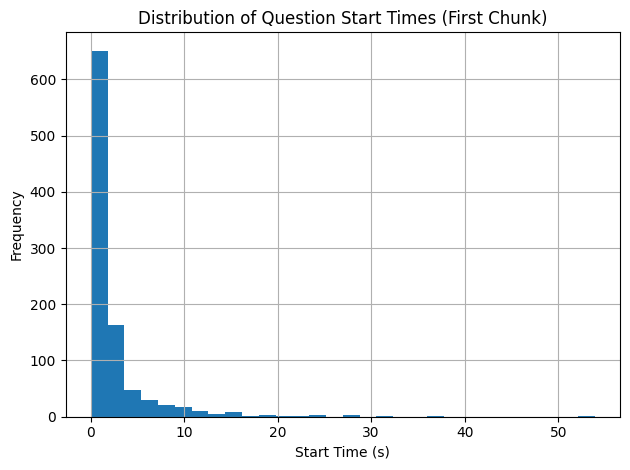


Summary stats for question start times:
count    969.000000
mean       2.427029
std        4.343494
min        0.031000
25%        0.419000
50%        1.145000
75%        2.309000
max       53.913000
Name: start_time, dtype: float64


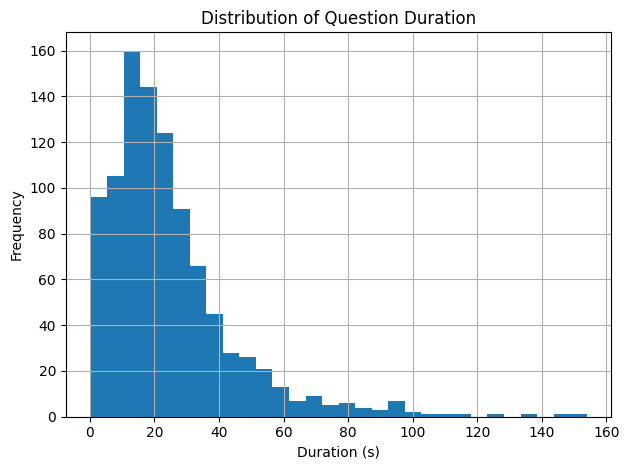


Summary stats for question durations:
count    969.000000
mean      24.509994
std       20.146719
min        0.193000
25%       11.630000
50%       19.966000
75%       31.542000
max      153.920000
Name: question_duration, dtype: float64


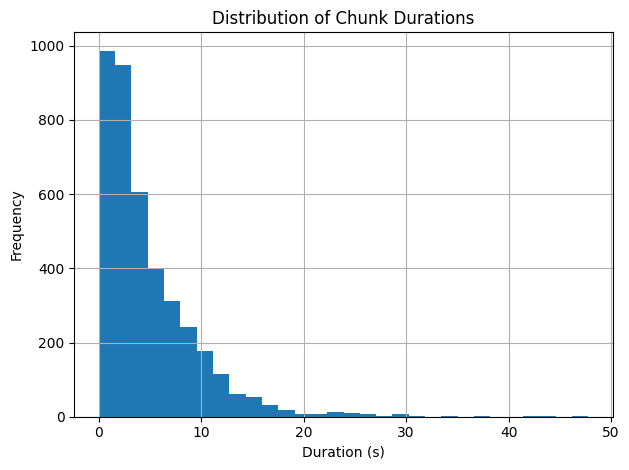


Summary stats for chunk durations:
count    4011.000000
mean        4.822954
std         4.660215
min         0.020000
25%         1.641000
50%         3.385000
75%         6.682000
max        47.760000
Name: chunk_duration, dtype: float64


In [7]:
# Load the aligned chunks
aligned_df = pd.read_csv("../Output/aligned_chunks.csv")

# --------------------------------------------------------------------
# 1. Distribution of question beginning (start time of first chunk)
# --------------------------------------------------------------------
first_chunks = aligned_df.sort_values(['subject_id', 'question', 'chunk_number']) \
                         .groupby(['subject_id', 'question'])['start_time'] \
                         .first()

plt.figure()
first_chunks.hist(bins=30)
plt.title("Distribution of Question Start Times (First Chunk)")
plt.xlabel("Start Time (s)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nSummary stats for question start times:")
print(first_chunks.describe())

# --------------------------------------------------------------------
# 2. Distribution of question length (time span from first to last chunk)
# --------------------------------------------------------------------
chunk_spans = aligned_df.groupby(['subject_id', 'question']) \
    .agg(first_start=('start_time', 'min'), last_end=('end_time', 'max'))
chunk_spans['question_duration'] = chunk_spans['last_end'] - chunk_spans['first_start']

plt.figure()
chunk_spans['question_duration'].hist(bins=30)
plt.title("Distribution of Question Duration")
plt.xlabel("Duration (s)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nSummary stats for question durations:")
print(chunk_spans['question_duration'].describe())

# --------------------------------------------------------------------
# 3. Distribution of individual chunk durations
# --------------------------------------------------------------------
aligned_df['chunk_duration'] = aligned_df['end_time'] - aligned_df['start_time']

plt.figure()
aligned_df['chunk_duration'].hist(bins=30)
plt.title("Distribution of Chunk Durations")
plt.xlabel("Duration (s)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nSummary stats for chunk durations:")
print(aligned_df['chunk_duration'].describe())

In [9]:
# --------------------------------------------------------------------
# PROMPT DEFINITIONS FOR SCORING FUNCTIONS
# --------------------------------------------------------------------

scoring_prompt= """You are an expert in cognitive psychology.

You are given a short chunk of a participant's think-aloud transcription during a reasoning task.

Your task is to rate how strongly this chunk expresses each of the following deliberation functions.

Definitions:

- Response Control: Refers to deliberately inhibiting or suppressing a generated response when it is deemed inappropriate for the given context. It often involves avoiding immediate reaction or blocking a response.

- Response Generation: Refers to actively generating new answers through the deliberate computation or mental simulation of solutions to a given problem. It often involves hypothetical thinking, algorithmic reasoning, or systematically working through steps to find solutions to a problem. 

- Response Justification: Refers to deliberately seeking explicit reasons, arguments, or rationalizations to support or scrutinize generated answers. It entails building explanations that clarify, validate or invalidate one’s judgments. It often involves giving reasons, referencing evidence, or explaining why an option makes sense or not.

- Response Regulation: Refers to deliberately monitoring and managing one’s own cognitive processes by allocating effort and resources strategically. It often involves reflective decisions about continuing or stopping deliberation, adjusting cognitive investment, or evaluating progress and coherence. 
Important Instructions:

- Each score should reflect the extent to which the chunk expresses the function using a continuous scale from 0 (not at all present) to 100 (extremely present).
- These functions are distinct, but not mutually exclusive — a chunk might score highly on multiple functions if they co-occur.
- If the chunk contains no trace of any of these 4 functions, assign 0 to all functions. This is perfectly acceptable.
- If the chunk expresses a completely different kind of function (not captured by the 4 above), do not mention it.
- Do not explain or justify the scores even if the chunk clearly expresses a different kind of function.

Output strictly in this structure (and nothing else):

Response Control: [score between 0 and 100]  
Response Generation: [score between 0 and 100]  
Response Justification: [score between 0 and 100]  
Response Regulation: [score between 0 and 100]  
"""


# Repetition and Consolidation
scoring_prompt_repetition = """
You are an expert in cognitive psychology.

You are given a short chunk of a participant's think-aloud transcription during a reasoning task.

Your task is to assess the presence of the following behavior:

**Repetition**  
Repetition refers to the mere repetition of information — such as repeating the question or response options.

Instructions:
- Score how strongly this behavior is present on a scale from 0 (not at all present) to 100 (extremely present).
- If the chunk contains no trace of this behavior, assign 0. This is perfectly acceptable.
- Output only the numeric score, no explanation.
"""

scoring_prompt_answer_selection = """
You are an expert in cognitive psychology.

You are given a short chunk of a participant's think-aloud transcription during a reasoning task.

Your task is to assess the presence of the following behavior:

**Answer Selection**  
Answer Selection refers to the participant selecting their chosen response option.

Instructions:
- Score how strongly this behavior is present on a scale from 0 (not at all present) to 100 (extremely present).
- If the chunk contains no trace of this behavior, assign 0. This is perfectly acceptable.
- Output only the numeric score, no explanation.
"""

# Confidence (no question context)
scoring_prompt_confidence = """
You are given a short chunk of a participant's think-aloud reasoning.

Estimate how confident the speaker sounds in this passage — based on how committed they seem to their ideas, how certain they appear, and whether they express doubt or hesitation.

Instructions:
- Give a score between 0 (not confident at all) and 100 (extremely confident).
- If you are uncertain, choose a midpoint score around 50.
- Output only the numeric score.
"""

In [ ]:
# --------------------------------------------------------------------
# 1. Config
# --------------------------------------------------------------------
LLAMA_MODEL  = "meta-llama/Llama-3.3-70B-Instruct"
TEMPERATURE  = 1
TOP_P        = 1
MAX_TOKENS   = 200
N            = 5
TESTING      = False
MAX_RETRIES  = 4
WAIT_SECONDS = 60
OVERWRITE    = False


# --------------------------------------------------------------------
# 2. Helpers
# --------------------------------------------------------------------
def parse_deliberation_scores(raw: list[str]) -> list[dict]:
    """
    Parse N completions that look like:
        Response Control: 12
        Response Generation: 34.5
        Response Justification: 0
        Response Regulation: 88
    Returns a list of length N, each item a dict with the four scores
    (floats). If anything is missing or un-parseable, NaN is inserted.
    """
    KEYS = ["control", "generation", "justification", "regulation"]
    pattern = re.compile(r"\d+(?:\.\d+)?")      # 0-100, accepts decimals

    parsed = []
    for txt in raw:
        # Drop empty lines the LLM might prepend/append
        lines = [ln for ln in txt.splitlines() if ln.strip()]
        scores = {}
        for i, key in enumerate(KEYS):
            try:
                num = pattern.search(lines[i]).group()
                scores[key] = float(num)
            except Exception:
                scores[key] = np.nan
        parsed.append(scores)

    return parsed

def parse_single_scores(raw: list[str]) -> list[float]:
    scores = []
    for txt in raw:
        m = re.search(r"\d+(?:\.\d+)?", txt)
        scores.append(float(m.group()) if m else np.nan)
    if len(scores) < N:
        scores.extend([np.nan] * (N - len(scores)))
    return scores

def query_llm(system_prompt: str, user_prompt: str, n: int = N,
              max_retries: int = MAX_RETRIES, wait: int = WAIT_SECONDS,
              parse_func=None) -> list:
    for attempt in range(1, max_retries + 1):
        try:
            response = client.chat.completions.create(
                model       = LLAMA_MODEL,
                messages    = [
                    {"role": "system", "content": system_prompt},
                    {"role": "user",   "content": user_prompt}
                ],
                max_tokens  = MAX_TOKENS,
                temperature = TEMPERATURE,
                top_p       = TOP_P,
                n           = n
            )
            raw_outputs = [c.message.content.strip() for c in response.choices]
            parsed = parse_func(raw_outputs)

            if isinstance(parsed[0], dict):
                # For deliberation: all scores in a dict
                if all(all(np.isnan(v) for v in d.values()) for d in parsed):
                    raise ValueError("All parsed scores are NaN.")
            else:
                # For confidence/repetition: single float scores
                if all(np.isnan(score) for score in parsed):
                    raise ValueError("All parsed scores are NaN.")

            return parsed

        except Exception as err:
            print(f"⚠️  LLM API call failed (attempt {attempt}/{max_retries}): {err}")
            print("   ↪️  Offending chunk:")
            print(user_prompt)
            if attempt < max_retries:
                print(f"   ⏳ Waiting {wait}s before retrying…")
                time.sleep(wait)
            else:
                print("❌  Final retry failed — returning NaN scores.")
                return [np.nan] * n if parse_func == parse_single_scores else [{k: np.nan for k in ["control", "generation", "justification", "regulation"]}] * n


# --------------------------------------------------------------------
# 3. Data
# --------------------------------------------------------------------
aligned_df = pd.read_csv("../Output/aligned_chunks.csv")
if TESTING:
    aligned_df = aligned_df.head(2)

out_path = "../Output/scored_chunks.csv"

meta_cols = ["subject_id", "question", "question_text", "correct_answer", "lured_answer"]
meta_dict = {(r.subject_id, r.question): r for _, r in data_long[meta_cols].iterrows()}

if os.path.exists(out_path) and not OVERWRITE:
    prev = pd.read_csv(out_path)
    done_keys = set(zip(prev.subject_id, prev.question, prev.chunk_id))
    results = prev.to_dict(orient="records")
    print(f"🔄  Resuming – {len(done_keys)} chunks already scored.")
else:
    done_keys, results = set(), []

PROMPT_MAP = {
    "deliberation": scoring_prompt,          # merged 4-function prompt
    "repetition": scoring_prompt_repetition,
    "answer_selection": scoring_prompt_answer_selection,
    "confidence": scoring_prompt_confidence
}
CONTEXT_PROMPTS = {"deliberation", "repetition", "answer_selection"}

# --------------------------------------------------------------------
# 4. Scoring loop
# --------------------------------------------------------------------
for idx, row in tqdm(aligned_df.iterrows(), total=len(aligned_df), desc="Scoring"):
    key = (row.subject_id, row.question, row.chunk_number)
    if key in done_keys:
        continue

    meta = meta_dict[(row.subject_id, row.question)]

    rec = {
        "subject_id": row.subject_id,
        "question":   row.question,
        "chunk_id":   row.chunk_number,
        "chunk_text": row.chunk_text,
        "start_time": row.start_time,
        "end_time":   row.end_time,
    }

    # --- Unified Deliberation Scoring ---
    user_prompt = (
f"Here is the question the participant was solving:\n\n"
f"'{meta.question_text}'\n\n"
f"The incorrect, intuitive answer is: '{meta.lured_answer}'\n"
f"The correct answer is: '{meta.correct_answer}'\n\n"
f"Here is the current chunk of the transcription:\n\n'{row.chunk_text}'"
    )
    parsed_dicts = query_llm(
        PROMPT_MAP["deliberation"],
        user_prompt,
        n=N,
        parse_func=parse_deliberation_scores
    )
    for func in ["control", "generation", "justification", "regulation"]:
        scores = [d[func] for d in parsed_dicts]
        rec[f"{func}_scores"] = json.dumps(scores)
        rec[f"{func}_mean"]   = np.nanmean(scores)

    # --- Single-score prompts (repetition, answer_selection, confidence) ---
    for label in ["repetition", "answer_selection", "confidence"]:
        user_prompt = (
            f"Here is the question the participant was solving:\n\n"
            f"'{meta.question_text}'\n\n"
            f"The incorrect, intuitive answer is: '{meta.lured_answer}'\n"
            f"The correct answer is: '{meta.correct_answer}'\n\n"
            f"Here is the current chunk of the transcription:\n\n'{row.chunk_text}'"
        ) if label in CONTEXT_PROMPTS else f"'{row.chunk_text}'"

        scores = query_llm(
            PROMPT_MAP[label],
            user_prompt,
            n=N,
            parse_func=parse_single_scores
        )
        rec[f"{label}_scores"] = json.dumps(scores)
        rec[f"{label}_mean"]   = np.nanmean(scores)

    results.append(rec)

    if (idx + 1) % 50 == 0:
        pd.DataFrame(results).to_csv(out_path, index=False)
        print(f"💾  Checkpoint written at chunk {idx+1}")

# --------------------------------------------------------------------
# 5. Final save
# --------------------------------------------------------------------
scored_df = pd.DataFrame(results).merge(
    data_long,
    on=["subject_id", "question"],
    how="left"
)
scored_df.to_csv(out_path, index=False)
print(f"✅  Finished scoring — {len(scored_df)} chunks written to {out_path}")

Scoring:   1%|          | 50/4011 [02:01<2:37:01,  2.38s/it]

💾  Checkpoint written at chunk 50


Scoring:   2%|▏         | 100/4011 [04:10<2:48:57,  2.59s/it]

💾  Checkpoint written at chunk 100


Scoring:   3%|▎         | 125/4011 [05:12<2:44:50,  2.55s/it]

⚠️  LLM API call failed (attempt 1/4): 503 Server Error: Service Temporarily Unavailable for url: https://api.together.xyz/v1/chat/completions

{'message': 'Service unavailable', 'type': 'service_unavailable'}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'A monkey, a squirrel, and a bird are racing to the top of a coconut tree. Who will get the banana first?'

The incorrect, intuitive answer is: 'Any animal'
The correct answer is: 'No banana on coconut tree'

Here is the current chunk of the transcription:

'Who will get the banana first, the monkey, the squirrel or the bird?'
   ⏳ Waiting 60s before retrying…


Scoring:   4%|▎         | 150/4011 [07:24<4:05:19,  3.81s/it] 

💾  Checkpoint written at chunk 150


Scoring:   5%|▍         | 200/4011 [09:19<2:23:47,  2.26s/it]

💾  Checkpoint written at chunk 200


Scoring:   6%|▌         | 250/4011 [11:39<3:07:55,  3.00s/it]

💾  Checkpoint written at chunk 250


Scoring:   7%|▋         | 300/4011 [14:13<2:38:09,  2.56s/it]

💾  Checkpoint written at chunk 300


Scoring:   9%|▊         | 350/4011 [16:32<2:40:33,  2.63s/it]

💾  Checkpoint written at chunk 350


Scoring:  10%|▉         | 400/4011 [18:36<1:50:58,  1.84s/it]

💾  Checkpoint written at chunk 400


Scoring:  11%|█         | 450/4011 [20:22<1:56:52,  1.97s/it]

💾  Checkpoint written at chunk 450


Scoring:  12%|█▏        | 500/4011 [22:20<2:10:35,  2.23s/it]

💾  Checkpoint written at chunk 500


Scoring:  13%|█▎        | 511/4011 [22:46<2:12:32,  2.27s/it]

⚠️  LLM API call failed (attempt 1/4): (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: f9e31ed5-1571-456c-a4e4-23d019137e26)')
   ↪️  Offending chunk:
Here is the question the participant was solving:

'Mary’s father has 5 daughters but no sons—Nana, Nene, Nini, Nono. What is the fifth daughter’s name probably?'

The incorrect, intuitive answer is: 'Nunu'
The correct answer is: 'Mary'

Here is the current chunk of the transcription:

'What is the fifth daughter's name probably'
   ⏳ Waiting 60s before retrying…


Scoring:  14%|█▎        | 550/4011 [25:12<2:01:50,  2.11s/it] 

💾  Checkpoint written at chunk 550


Scoring:  15%|█▍        | 600/4011 [27:09<2:27:48,  2.60s/it]

💾  Checkpoint written at chunk 600


Scoring:  16%|█▌        | 642/4011 [29:21<8:34:20,  9.16s/it]

⚠️  LLM API call failed (attempt 1/4): 500 Server Error: Internal Server Error for url: https://api.together.xyz/v1/chat/completions (Request ID: nrv2t1F-2j9zxn-937776aedbb174cd)

{'message': 'Internal server error', 'type': 'server_error', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'It’s a stormy night and a plane crashes - in which country do you bury the survivors?'

The incorrect, intuitive answer is: 'Burial location'
The correct answer is: 'Don't bury survivors'

Here is the current chunk of the transcription:

'I don't know.'
   ⏳ Waiting 60s before retrying…


Scoring:  16%|█▌        | 650/4011 [30:48<4:07:51,  4.42s/it] 

💾  Checkpoint written at chunk 650


Scoring:  17%|█▋        | 700/4011 [33:07<2:10:56,  2.37s/it]

💾  Checkpoint written at chunk 700


Scoring:  19%|█▊        | 750/4011 [35:16<1:50:15,  2.03s/it]

💾  Checkpoint written at chunk 750


Scoring:  20%|█▉        | 800/4011 [37:16<2:52:54,  3.23s/it]

💾  Checkpoint written at chunk 800


Scoring:  21%|██        | 850/4011 [39:26<2:06:22,  2.40s/it]

💾  Checkpoint written at chunk 850


Scoring:  22%|██▏       | 900/4011 [41:27<2:00:34,  2.33s/it]

💾  Checkpoint written at chunk 900


Scoring:  24%|██▎       | 950/4011 [43:26<2:04:23,  2.44s/it]

💾  Checkpoint written at chunk 950


Scoring:  25%|██▍       | 1000/4011 [45:37<1:49:31,  2.18s/it]

💾  Checkpoint written at chunk 1000


Scoring:  26%|██▌       | 1050/4011 [48:14<1:53:21,  2.30s/it]

💾  Checkpoint written at chunk 1050


Scoring:  27%|██▋       | 1097/4011 [50:38<5:50:21,  7.21s/it]

⚠️  LLM API call failed (attempt 1/4): 500 Server Error: Internal Server Error for url: https://api.together.xyz/v1/chat/completions (Request ID: nrv9TEK-2j9zxn-937795fe0b37d0bb)

{'message': 'Internal server error', 'type': 'server_error', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'If you have only one match and you walk into a dark room with an oil lamp, a newspaper and wood—which thing would you light first?'

The incorrect, intuitive answer is: 'Oil lamp / Newspaper / Wood'
The correct answer is: 'Match'

Here is the current chunk of the transcription:

'You would light the match.'
   ⏳ Waiting 60s before retrying…


Scoring:  27%|██▋       | 1100/4011 [51:53<11:18:21, 13.98s/it]

💾  Checkpoint written at chunk 1100


Scoring:  29%|██▊       | 1150/4011 [54:01<1:47:06,  2.25s/it] 

💾  Checkpoint written at chunk 1150


Scoring:  30%|██▉       | 1200/4011 [55:58<1:31:51,  1.96s/it]

💾  Checkpoint written at chunk 1200


Scoring:  31%|███       | 1250/4011 [57:56<1:49:13,  2.37s/it]

💾  Checkpoint written at chunk 1250


Scoring:  32%|███▏      | 1300/4011 [1:00:13<2:12:53,  2.94s/it]

💾  Checkpoint written at chunk 1300


Scoring:  34%|███▎      | 1350/4011 [1:02:25<1:48:53,  2.46s/it]

💾  Checkpoint written at chunk 1350


Scoring:  35%|███▍      | 1389/4011 [1:04:22<5:01:36,  6.90s/it]

⚠️  LLM API call failed (attempt 1/4): 500 Server Error: Internal Server Error for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvDeXM-2j9zxn-9377a9f95a649ec6)

{'message': 'Internal server error', 'type': 'server_error', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'Would it be ethical for a man to marry the sister of his widow?'

The incorrect, intuitive answer is: 'Yes / No'
The correct answer is: 'Not possible'

Here is the current chunk of the transcription:

'Would it be ethical for a man to marry the sister of his widow? The sister of his widow.'
   ⏳ Waiting 60s before retrying…


Scoring:  35%|███▍      | 1394/4011 [1:05:42<6:36:21,  9.09s/it] 

⚠️  LLM API call failed (attempt 1/4): 500 Server Error: Internal Server Error for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvE47p-3NKUce-9377abe8df2b9ec6)

{'message': 'Internal server error', 'type': 'server_error', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'Would it be ethical for a man to marry the sister of his widow?'

The incorrect, intuitive answer is: 'Yes / No'
The correct answer is: 'Not possible'

Here is the current chunk of the transcription:

'To marry the sister of his widow.'
   ⏳ Waiting 60s before retrying…


Scoring:  35%|███▍      | 1400/4011 [1:06:55<4:23:01,  6.04s/it] 

💾  Checkpoint written at chunk 1400


Scoring:  36%|███▌      | 1450/4011 [1:08:49<1:19:02,  1.85s/it]

💾  Checkpoint written at chunk 1450


Scoring:  37%|███▋      | 1500/4011 [1:10:54<1:52:30,  2.69s/it]

💾  Checkpoint written at chunk 1500


Scoring:  39%|███▊      | 1550/4011 [1:12:56<1:59:16,  2.91s/it]

💾  Checkpoint written at chunk 1550


Scoring:  40%|███▉      | 1600/4011 [1:15:04<1:32:30,  2.30s/it]

💾  Checkpoint written at chunk 1600


Scoring:  41%|████      | 1650/4011 [1:16:53<1:20:00,  2.03s/it]

💾  Checkpoint written at chunk 1650


Scoring:  42%|████▏     | 1700/4011 [1:18:37<1:23:41,  2.17s/it]

💾  Checkpoint written at chunk 1700


Scoring:  44%|████▎     | 1750/4011 [1:20:25<1:31:18,  2.42s/it]

💾  Checkpoint written at chunk 1750


Scoring:  45%|████▍     | 1793/4011 [1:22:16<1:31:18,  2.47s/it]

⚠️  LLM API call failed (attempt 1/4): 503 Server Error: Service Unavailable for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvKAFB-2j9zxn-9377c439fa7ba649)

{'message': 'Service unavailable', 'type': 'service_unavailable', 'param': None, 'code': None}
   ↪️  Offending chunk:
'So what are you asking me? I don't know.'
   ⏳ Waiting 60s before retrying…


Scoring:  45%|████▍     | 1800/4011 [1:23:34<2:44:51,  4.47s/it] 

💾  Checkpoint written at chunk 1800


Scoring:  45%|████▌     | 1811/4011 [1:24:06<1:43:10,  2.81s/it]

⚠️  LLM API call failed (attempt 1/4): 503 Server Error: Service Unavailable for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvKjCJ-3NKUce-9377c6efec6da649)

{'message': 'Service unavailable', 'type': 'service_unavailable', 'param': None, 'code': None}
   ↪️  Offending chunk:
'The monkey, the squirrel or the bird?'
   ⏳ Waiting 60s before retrying…


Scoring:  45%|████▌     | 1816/4011 [1:25:23<4:29:42,  7.37s/it] 

⚠️  LLM API call failed (attempt 1/4): 503 Server Error: Service Unavailable for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvL7PJ-3NKUce-9377c8c0b9a2a649)

{'message': 'Service unavailable', 'type': 'service_unavailable', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'In a one-storey pink house with everything pink, what colour were the stairs probably?'

The incorrect, intuitive answer is: 'Pink'
The correct answer is: 'No stairs'

Here is the current chunk of the transcription:

'In a one-starry pink house, there was a pink person, a pink cat, a pink fish, a pink chair, a pink tablecloth.'
   ⏳ Waiting 60s before retrying…


Scoring:  46%|████▌     | 1842/4011 [1:27:28<1:13:04,  2.02s/it] 

⚠️  LLM API call failed (attempt 1/4): 503 Server Error: Service Unavailable for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvLkrg-2j9zxn-9377cbd69964a649)

{'message': 'Service unavailable', 'type': 'service_unavailable', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'It’s a stormy night and a plane crashes - in which country do you bury the survivors?'

The incorrect, intuitive answer is: 'Burial location'
The correct answer is: 'Don't bury survivors'

Here is the current chunk of the transcription:

'Don't forget to keep reading and thinking aloud in America.'
   ⏳ Waiting 60s before retrying…


Scoring:  46%|████▌     | 1850/4011 [1:28:47<2:16:24,  3.79s/it] 

💾  Checkpoint written at chunk 1850


Scoring:  47%|████▋     | 1900/4011 [1:30:35<1:22:02,  2.33s/it]

💾  Checkpoint written at chunk 1900


Scoring:  49%|████▊     | 1950/4011 [1:32:32<1:48:45,  3.17s/it]

💾  Checkpoint written at chunk 1950


Scoring:  49%|████▉     | 1962/4011 [1:32:56<1:09:27,  2.03s/it]

⚠️  LLM API call failed (attempt 1/4): 500 Server Error: Internal Server Error for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvNSYA-2j9zxn-9377d3daec7ca649)

{'message': 'Internal server error', 'type': 'server_error', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'Which sentence is correct: (a) 'the yolk of the egg are white' or (b) 'the yolk of the egg is white'?'

The incorrect, intuitive answer is: 'b'
The correct answer is: 'The yolk is yellow'

Here is the current chunk of the transcription:

'Well, the yolk is actually yellow, so neither sentence would be correct.'
   ⏳ Waiting 60s before retrying…


Scoring:  50%|████▉     | 2000/4011 [1:35:59<1:34:49,  2.83s/it] 

💾  Checkpoint written at chunk 2000


Scoring:  51%|█████     | 2050/4011 [1:38:06<1:12:23,  2.21s/it]

💾  Checkpoint written at chunk 2050


Scoring:  52%|█████▏    | 2072/4011 [1:39:05<1:22:37,  2.56s/it]

⚠️  LLM API call failed (attempt 1/4): 500 Server Error: Internal Server Error for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvQLBP-3NKUce-9377dcda2bb1d0b6)

{'message': 'Internal server error', 'type': 'server_error', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'In a one-storey pink house with everything pink, what colour were the stairs probably?'

The incorrect, intuitive answer is: 'Pink'
The correct answer is: 'No stairs'

Here is the current chunk of the transcription:

'There we go.'
   ⏳ Waiting 60s before retrying…


Scoring:  52%|█████▏    | 2100/4011 [1:41:14<1:16:25,  2.40s/it] 

💾  Checkpoint written at chunk 2100


Scoring:  52%|█████▏    | 2104/4011 [1:41:24<1:14:13,  2.34s/it]

⚠️  LLM API call failed (attempt 1/4): 503 Server Error: Service Unavailable for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvR4wg-3NKUce-9377e061acf7d0b6)

{'message': 'Service unavailable', 'type': 'service_unavailable', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'Which sentence is correct: (a) 'the yolk of the egg are white' or (b) 'the yolk of the egg is white'?'

The incorrect, intuitive answer is: 'b'
The correct answer is: 'The yolk is yellow'

Here is the current chunk of the transcription:

'oh I don't know hang on neither are right other than you've used are and is the yolk egg white the yolk of the egg are white the oak of the egg is white'
   ⏳ Waiting 60s before retrying…
⚠️  LLM API call failed (attempt 1/4): 500 Server Error: Internal Server Error for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvRP8E-3NKUce-9377e1dfbc83d0b6)

{'message': 'Internal server error', 'type':

Scoring:  54%|█████▎    | 2150/4011 [1:45:37<1:16:09,  2.46s/it] 

💾  Checkpoint written at chunk 2150


Scoring:  55%|█████▍    | 2200/4011 [1:47:32<1:05:29,  2.17s/it]

💾  Checkpoint written at chunk 2200


Scoring:  56%|█████▌    | 2250/4011 [1:49:49<1:37:50,  3.33s/it]

💾  Checkpoint written at chunk 2250


Scoring:  57%|█████▋    | 2300/4011 [1:53:26<1:22:02,  2.88s/it]

💾  Checkpoint written at chunk 2300


Scoring:  59%|█████▊    | 2350/4011 [1:55:49<1:08:01,  2.46s/it]

💾  Checkpoint written at chunk 2350


Scoring:  60%|█████▉    | 2400/4011 [1:57:43<58:38,  2.18s/it]  

💾  Checkpoint written at chunk 2400


Scoring:  61%|██████    | 2450/4011 [1:59:44<51:59,  2.00s/it]  

💾  Checkpoint written at chunk 2450


Scoring:  62%|██████▏   | 2500/4011 [2:01:42<1:09:02,  2.74s/it]

💾  Checkpoint written at chunk 2500


Scoring:  63%|██████▎   | 2533/4011 [2:03:48<3:07:25,  7.61s/it]

⚠️  LLM API call failed (attempt 1/4): 503 Server Error: Service Unavailable for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvXwKJ-2j9zxn-937801173959036b)

{'message': 'Service unavailable', 'type': 'service_unavailable', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'A monkey, a squirrel, and a bird are racing to the top of a coconut tree. Who will get the banana first?'

The incorrect, intuitive answer is: 'Any animal'
The correct answer is: 'No banana on coconut tree'

Here is the current chunk of the transcription:

'So I don't think there's a banana there.'
   ⏳ Waiting 60s before retrying…


Scoring:  63%|██████▎   | 2534/4011 [2:05:00<11:03:19, 26.95s/it]

⚠️  LLM API call failed (attempt 1/4): 500 Server Error: Internal Server Error for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvYHvR-3NKUce-937802c9f8b3036b)

{'message': 'Internal server error', 'type': 'server_error', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'A monkey, a squirrel, and a bird are racing to the top of a coconut tree. Who will get the banana first?'

The incorrect, intuitive answer is: 'Any animal'
The correct answer is: 'No banana on coconut tree'

Here is the current chunk of the transcription:

'So none of them is the answer.'
   ⏳ Waiting 60s before retrying…
⚠️  LLM API call failed (attempt 1/4): 503 Server Error: Service Unavailable for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvYd8e-3NKUce-9378045c1d4d036b)

{'message': 'Service unavailable', 'type': 'service_unavailable', 'param': None, 'code': None}
   ↪️  Offending chunk:
'So none of them is the answer.'


Scoring:  63%|██████▎   | 2541/4011 [2:08:59<10:34:57, 25.92s/it]

⚠️  LLM API call failed (attempt 1/4): 503 Server Error: Service Unavailable for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvZX3q-3NKUce-9378089cfa86036b)

{'message': 'Service unavailable', 'type': 'service_unavailable', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'How many of each animal did Moses put on the ark?'

The incorrect, intuitive answer is: 'Two'
The correct answer is: 'nan'

Here is the current chunk of the transcription:

'He put two of each animal.'
   ⏳ Waiting 60s before retrying…
⚠️  LLM API call failed (attempt 1/4): 500 Server Error: Internal Server Error for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvZqgN-3NKUce-93780a29d887036b)

{'message': 'Internal server error', 'type': 'server_error', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'How many of each animal did Moses put on the ark?'

The incorrect, in

Scoring:  63%|██████▎   | 2544/4011 [2:11:41<14:17:54, 35.09s/it]

⚠️  LLM API call failed (attempt 1/4): 503 Server Error: Service Unavailable for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvaNU7-2j9zxn-93780cb02c36036b)

{'message': 'Service unavailable', 'type': 'service_unavailable', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'The wind blows west. An electric train runs east. In which direction does the smoke blow?'

The incorrect, intuitive answer is: 'West'
The correct answer is: 'No smoke'

Here is the current chunk of the transcription:

'The wind blows west. An electric train runs east. In which cardinal direction does the smoke from the locomotive blow?'
   ⏳ Waiting 60s before retrying…


Scoring:  64%|██████▎   | 2550/4011 [2:13:24<4:57:07, 12.20s/it] 

💾  Checkpoint written at chunk 2550


Scoring:  65%|██████▍   | 2600/4011 [2:18:53<1:24:13,  3.58s/it]

💾  Checkpoint written at chunk 2600


Scoring:  66%|██████▌   | 2650/4011 [2:21:33<50:14,  2.21s/it]  

💾  Checkpoint written at chunk 2650


Scoring:  67%|██████▋   | 2700/4011 [2:23:59<1:17:39,  3.55s/it]

💾  Checkpoint written at chunk 2700


Scoring:  69%|██████▊   | 2750/4011 [2:26:28<53:48,  2.56s/it]  

💾  Checkpoint written at chunk 2750


Scoring:  70%|██████▉   | 2800/4011 [2:28:54<45:56,  2.28s/it]  

💾  Checkpoint written at chunk 2800


Scoring:  71%|███████   | 2850/4011 [2:31:19<50:41,  2.62s/it]  

💾  Checkpoint written at chunk 2850


Scoring:  72%|███████▏  | 2900/4011 [2:33:57<1:05:21,  3.53s/it]

💾  Checkpoint written at chunk 2900


Scoring:  73%|███████▎  | 2921/4011 [2:35:30<1:07:19,  3.71s/it]

⚠️  LLM API call failed (attempt 1/4): 503 Server Error: Service Unavailable for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvhgMV-3NKUce-93782f7efb18ad3a)

{'message': 'Service unavailable', 'type': 'service_unavailable', 'param': None, 'code': None}
   ↪️  Offending chunk:
'Noah put them on the ark.'
   ⏳ Waiting 60s before retrying…


Scoring:  73%|███████▎  | 2935/4011 [2:37:04<50:57,  2.84s/it]  

⚠️  LLM API call failed (attempt 1/4): 503 Server Error: Service Unavailable for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvi9tS-2j9zxn-937831c3581dad3a)

{'message': 'Service unavailable', 'type': 'service_unavailable', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'Would it be ethical for a man to marry the sister of his widow?'

The incorrect, intuitive answer is: 'Yes / No'
The correct answer is: 'Not possible'

Here is the current chunk of the transcription:

'This one's going to make me think, actually.'
   ⏳ Waiting 60s before retrying…
⚠️  LLM API call failed (attempt 1/4): 503 Server Error: Service Unavailable for url: https://api.together.xyz/v1/chat/completions (Request ID: nrviVKh-2j9zxn-9378335bf9a4ad3a)

{'message': 'Service unavailable', 'type': 'service_unavailable', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'Would it be ethical 

Scoring:  74%|███████▎  | 2950/4011 [2:39:53<49:59,  2.83s/it]   

💾  Checkpoint written at chunk 2950


Scoring:  74%|███████▍  | 2961/4011 [2:40:34<1:30:48,  5.19s/it]

⚠️  LLM API call failed (attempt 1/4): 503 Server Error: Service Unavailable for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvjEN7-2j9zxn-937836e4ce5cad3a)

{'message': 'Service unavailable', 'type': 'service_unavailable', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'If you have only one match and you walk into a dark room with an oil lamp, a newspaper and wood—which thing would you light first?'

The incorrect, intuitive answer is: 'Oil lamp / Newspaper / Wood'
The correct answer is: 'Match'

Here is the current chunk of the transcription:

'Well, you couldn't like nothing because that was no clue to it later.'
   ⏳ Waiting 60s before retrying…
⚠️  LLM API call failed (attempt 2/4): 503 Server Error: Service Unavailable for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvjYRG-2j9zxn-9378385f1ee1ad3a)

{'message': 'Service unavailable', 'type': 'service_unavailable', 'param': None, 'code'

Scoring:  74%|███████▍  | 2962/4011 [2:42:38<11:51:35, 40.70s/it]

⚠️  LLM API call failed (attempt 1/4): 503 Server Error: Service Unavailable for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvjscL-3NKUce-937839f228fead3a)

{'message': 'Service unavailable', 'type': 'service_unavailable', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'If you have only one match and you walk into a dark room with an oil lamp, a newspaper and wood—which thing would you light first?'

The incorrect, intuitive answer is: 'Oil lamp / Newspaper / Wood'
The correct answer is: 'Match'

Here is the current chunk of the transcription:

'Of course, we have how much, so I didn't read that before.'
   ⏳ Waiting 60s before retrying…


Scoring:  74%|███████▍  | 2971/4011 [2:44:10<1:41:27,  5.85s/it] 

⚠️  LLM API call failed (attempt 1/4): 503 Server Error: Service Unavailable for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvkLWH-2j9zxn-93783c2968efad3a)

{'message': 'Service unavailable', 'type': 'service_unavailable', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'Which sentence is correct: (a) 'the yolk of the egg are white' or (b) 'the yolk of the egg is white'?'

The incorrect, intuitive answer is: 'b'
The correct answer is: 'The yolk is yellow'

Here is the current chunk of the transcription:

'It might be that, if you'll see, it's so hard to see.'
   ⏳ Waiting 60s before retrying…


Scoring:  74%|███████▍  | 2972/4011 [2:45:13<6:37:36, 22.96s/it]

⚠️  LLM API call failed (attempt 1/4): 503 Server Error: Service Unavailable for url: https://api.together.xyz/v1/chat/completions (Request ID: nrvkfcr-3NKUce-93783db8fe53ad3a)

{'message': 'Service unavailable', 'type': 'service_unavailable', 'param': None, 'code': None}
   ↪️  Offending chunk:
Here is the question the participant was solving:

'Mary’s father has 5 daughters but no sons—Nana, Nene, Nini, Nono. What is the fifth daughter’s name probably?'

The incorrect, intuitive answer is: 'Nunu'
The correct answer is: 'Mary'

Here is the current chunk of the transcription:

'Please remember that. Mary's father has five daughters but no sons. Nana, Nini, Nini.'
   ⏳ Waiting 60s before retrying…


Scoring:  75%|███████▍  | 3000/4011 [2:47:29<49:13,  2.92s/it]   

💾  Checkpoint written at chunk 3000


Scoring:  76%|███████▌  | 3044/4011 [2:49:44<37:29,  2.33s/it]  